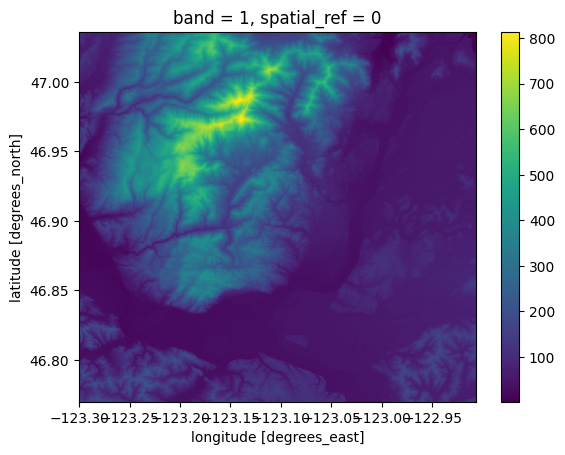

In [397]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd  # Vector data handling
import osmnx as ox       # Downloading data from OSM

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

import geojson

import shapely

# import matplotlib

# Displays a topographical map within coordinates selected
dem = rioxarray.open_rasterio('./rem-files/FullAreaOfRivers.tif')

# Area coordinates for all three rivers
# geom = '''{"type": "Polygon",
#                 "coordinates":[[
#                 [-123.2408442129,46.6602109019],
#                 [-121.7264279122,46.6602109019],
#                 [-121.7264279122,47.1258587757],
#                 [-123.2408442129,47.1258587757],
#                 [-123.2408442129,46.6602109019]]]}'''

# Deschutes River area coordinates
# geom = '''{"type": "Polygon",
#                 "coordinates":[[
#                 [-122.9387355902,46.6602109019],
#                 [-122.3434306967,46.6602109019],
#                 [-122.3434306967,47.0654867007],
#                 [-122.9387355902,47.0654867007],
#                 [-122.9387355902,46.6602109019]]]}'''

# Black River area coordinates
geom = '''{"type": "Polygon",
                "coordinates":[[
                [-123.2999739814,46.7700443882],
                [-122.9069593705,46.7700443882],
                [-122.9069593705,47.035708864],
                [-123.2999739814,47.035708864],
                [-123.2999739814,46.7700443882]]]}'''

# Nisqually River area coordinates
# geom = '''{"type": "Polygon",
#                 "coordinates":[[
#                 [-122.7355875775,46.6602109019],
#                 [-121.7264279122,46.6602109019],
#                 [-121.7264279122,47.1258587757],
#                 [-122.7355875775,47.1258587757],
#                 [-122.7355875775,46.6602109019]]]}'''

cropping_geometries = [geojson.loads(geom)]
cropped = dem.rio.clip(geometries=cropping_geometries, crs=4326)

cropped = cropped.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

cropped.squeeze().plot.imshow()


<Axes: >

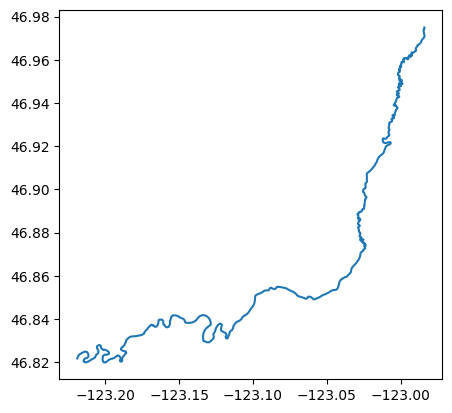

In [398]:
# Displays entire river that is specified
# Deschutes River
# river = ox.geocode_to_gdf('Deschutes River, Washington', which_result=1)
# river = river.to_crs(cropped.rio.crs)

# river.plot()

# Black River
river_1 = ox.geocode_to_gdf('Black River, Washington', which_result=2) # which_result = number for which indexed image
river_1 = river_1.to_crs(cropped.rio.crs)

river_1.plot()

# Nisqually River
# river_2 = ox.geocode_to_gdf('Nisqually River, Washington', which_result=1)
# river_2 = river_2.to_crs(cropped.rio.crs)

# river_2.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

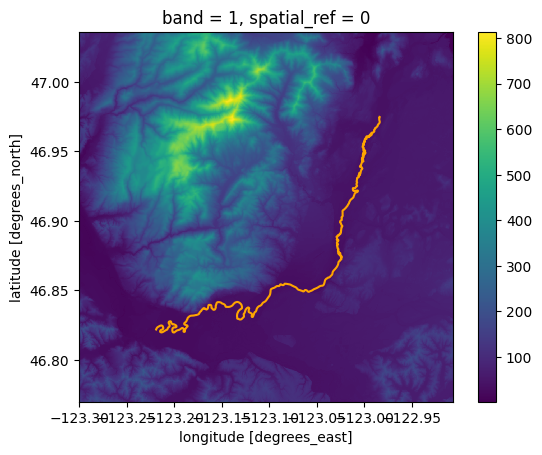

In [399]:
# Displays topographical map with river combined
cropped.rio.bounds()

bounds = cropped.rio.bounds()
xmin, ymin, xmax, ymax = bounds

# Deschutes River
# river = river.clip(bounds)

# river_geom = river.geometry.iloc[0]
# river_geom

# Black River
river_1 = river_1.clip(bounds)

river_geom_1 = river_1.geometry.iloc[0]
river_geom_1

# Nisqually River
# river_2 = river_2.clip(bounds)

# river_geom_2 = river_2.geometry.iloc[0]
# river_geom_2

cropped = cropped.sel(y=slice(ymax, ymin), x=slice(xmin, xmax))

fig, ax = plt.subplots()
cropped.squeeze().plot.imshow(ax=ax)
# Deschutes River
# river.plot(ax=ax, color='blue')

# Black River
river_1.plot(ax=ax, color='orange')

# Nisqually River
# river_2.plot(ax=ax, color='green')


<Axes: xlabel='x', ylabel='y'>

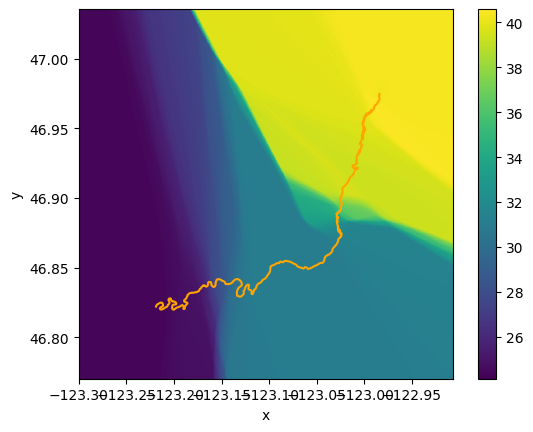

In [400]:
# Smooth representation of different elevation on topographic map
def split_coords(geom):
    x = []
    y = []
    for i in shapely.get_coordinates(geom):
        x.append(i[0])
        y.append(i[1])
    return x, y

# Deschutes River
# xs, ys = split_coords(river_geom)

# Black River
xs, ys = split_coords(river_geom_1)

# Nisqually River
# xs, ys = split_coords(river_geom_2)

xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')

sampled = cropped.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

# Sampled river coordinates
c_sampled = np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
c_x, c_y = [cropped.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = sampled.values.ravel()
c_interpolate

tree = KDTree(c_sampled)

# IWD interpolation
distances, indices = tree.query(c_interpolate, k=50) # k value changes smoothness

weights = 1 / distances
weights = weights / weights.sum(axis=1).reshape(-1, 1)

interpolated_values = (weights * values[indices]).sum(axis=1)
interpolated_values

elevation_raster = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

fig, ax = plt.subplots()
elevation_raster.transpose().plot.imshow(ax=ax)

# Deschutes River
# river.plot(ax=ax, color='blue')

# Black River
river_1.plot(ax=ax, color='orange')

# Nisqually River
# river_2.plot(ax=ax, color='green')


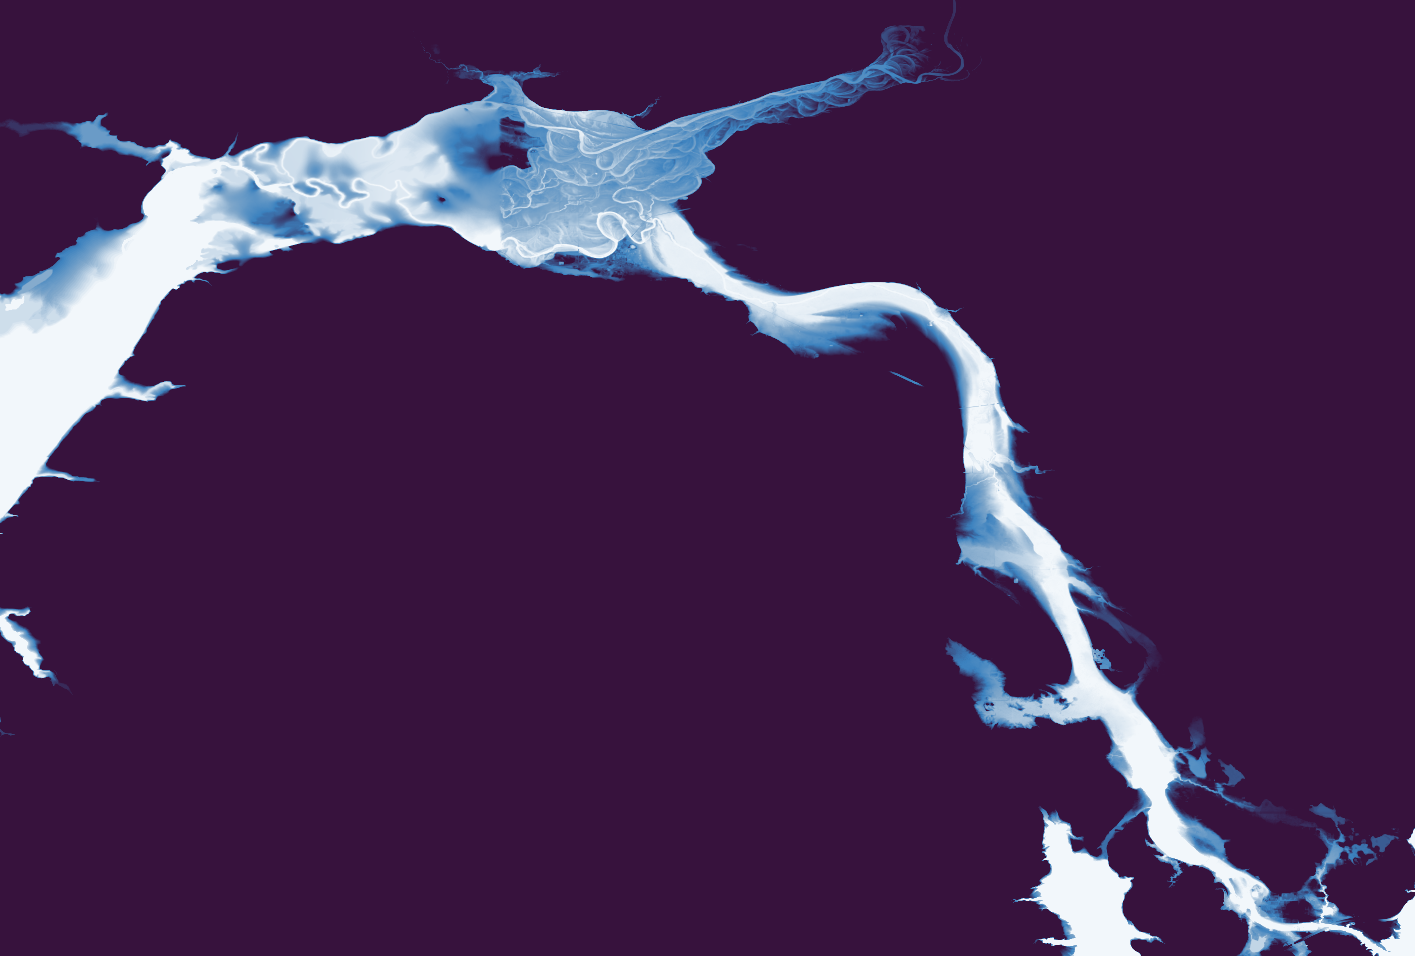

In [401]:
# Full representation of river levels
rem = cropped - elevation_raster

# colors = ['#FFFFFF', '#ADD8E6', '#6C3BAA']
colors = ['#f2f7fb', '#81a8cb', "#3c82bf",'#37123d']
# colors = ["#f2fbff","#26cbfd", "#0558ff", "#123d21", "#042b11"]

shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear')


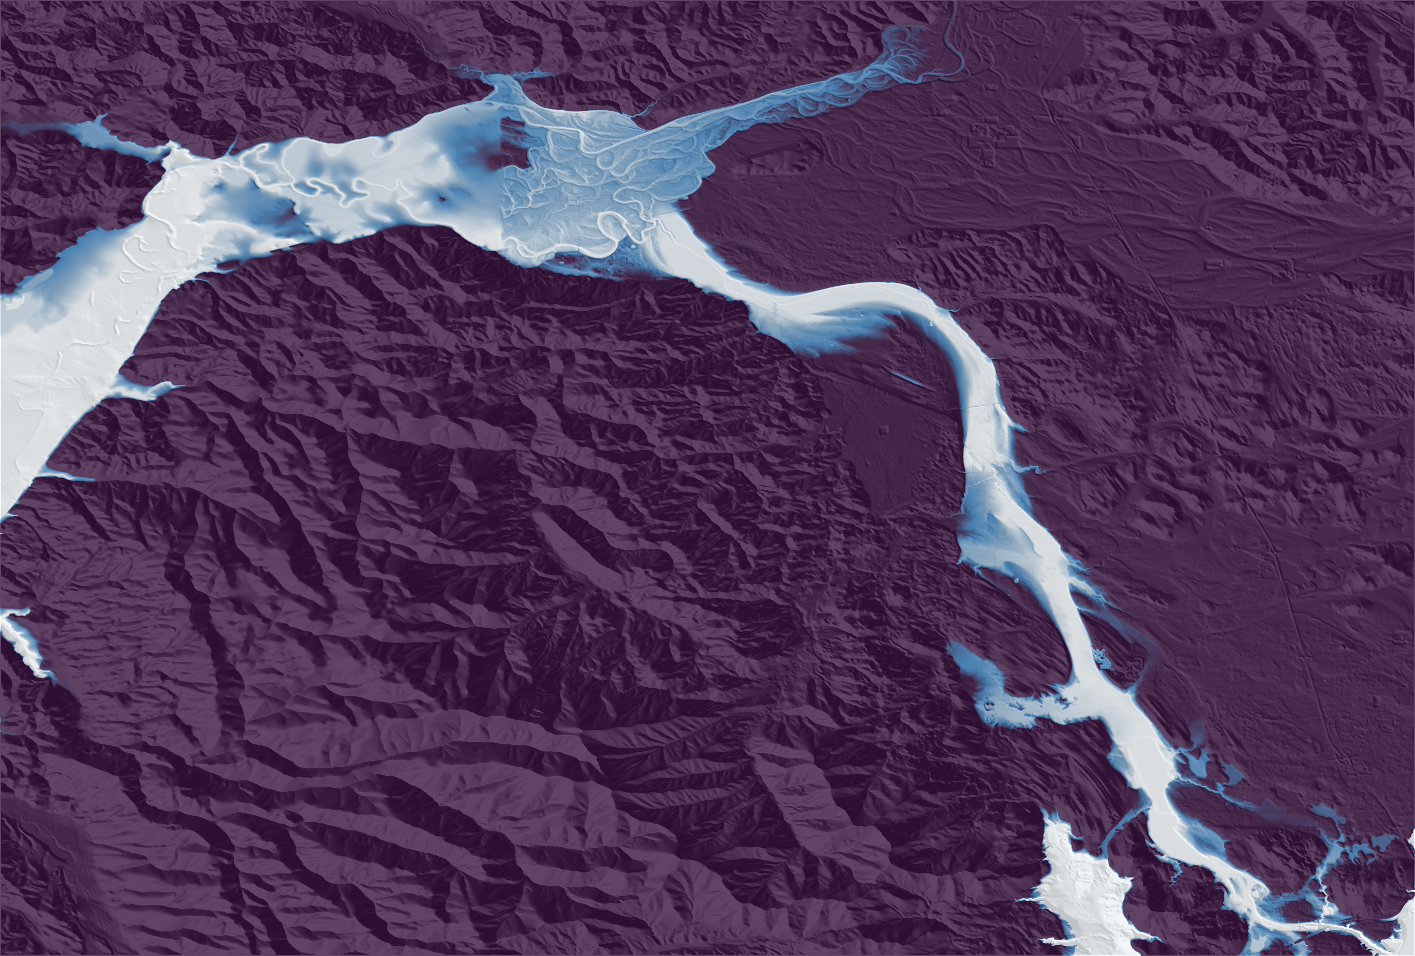

In [402]:
# Final full representation of river levels
a = shade(xrspatial.hillshade(cropped.squeeze(), angle_altitude=1, azimuth=310), cmap=['black', 'white'], how='linear')
b = shade(rem.squeeze(), cmap=colors, span=[0, 10], how='linear', alpha=200) # Alpha values 0 and 225 for transparency
stack(a, b)
